In [1]:
import glob
import os
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Align import PairwiseAligner
from Bio.SeqUtils import nt_search

In [2]:
def umi_histogram(fastq_path, max_count):
    conscount_values = []
    
    # Regular expression to find CONSCOUNT field and extract the number
    pattern = re.compile(r"CONSCOUNT=(\d+)")

    # Parse the fastq file
    with open(fastq_path, "r") as handle:
        for record in SeqIO.parse(handle, "fastq"):
            match = pattern.search(record.description)
            if match:
                conscount = int(match.group(1))
                # All values greater than max_count are set to max_count
                conscount = min(conscount, max_count)
                conscount_values.append(conscount)
    
    # Plot the histogram
    # bins should be one more than max_count to include the last bin
    plt.hist(conscount_values, bins=max_count+1, range=(0, max_count+1), edgecolor='black')
    
    fastq_basename = fastq_path.split('/')[-1]
    plt.title(f'Distribution of CONSCOUNT for {fastq_basename}')
    plt.xlabel('CONSCOUNT')
    plt.ylabel('Frequency')
    
    ticks = list(range(0, max_count + 1))
    labels = [str(i) for i in range(0, max_count)] + [f"=>{max_count}"]
    plt.xticks(ticks, labels, rotation=90)
    
    plt.show()


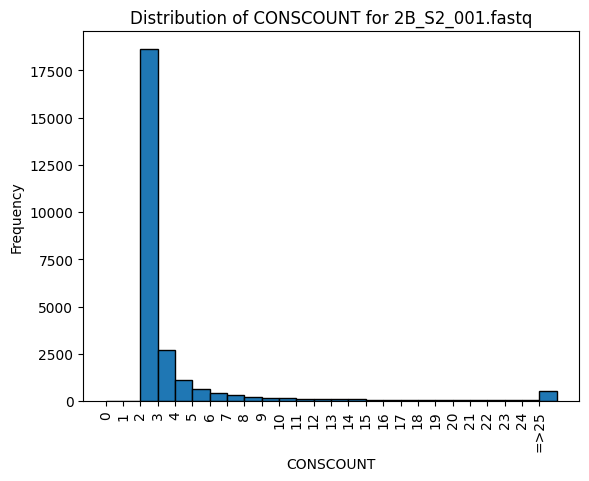

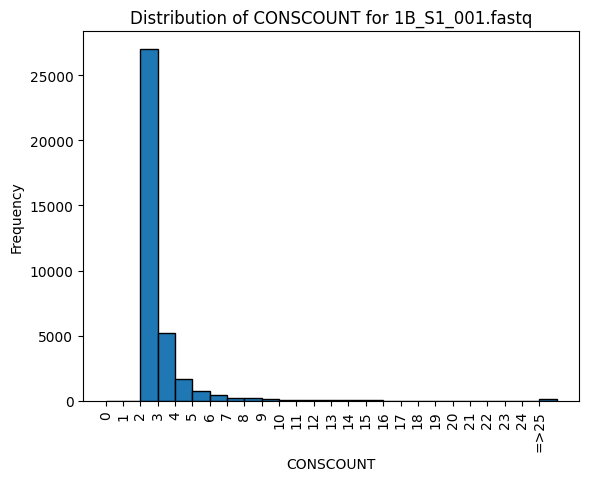

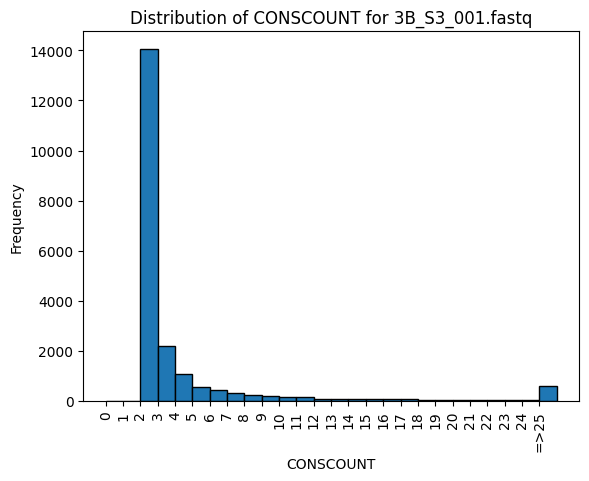

In [3]:
for path in glob.glob("/Users/matsen/re/gcreplay/nextflow/data/passenger/test_run/unique_with_at_least_two_reads/*.fastq"):
    umi_histogram(path, 25)


In [4]:
chigy_lc_stop_with_leader_and_intron = "CATGGAGTCACAGACTCAGGTCTTTGTAGTTGTCTGGTGTTGATGGAGACATTGTGATGACtCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACtAAGCTaGAAATAAAACgtaagtacacttttctcatctttttttatgtgtaagacacaggttttgca".upper()

chigy_lc_stop_trimmed = "GACATTGTGATGACtCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACtAAGCTaGAAATAAAAC".upper()

chigy_lc_stop = chigy_lc_stop_with_leader_and_intron

chigy_original = "CATGGAGTCACAGACTCAGGTCTTTGTATACATGTTGCTGTGGTTGTCTGGTGTTGATGGAGACATTGTGATGACtCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACtAAGCTaGAAATAAAACgtaagtacacttttctcatctttttttatgtgtaagacacaggttttgca".upper()

deleted_segment = "tacatgttgctgtg".upper()

In [5]:
def process_excel_sequences(file_path):
    df = pd.read_excel(file_path)
    df["Sequence"] = df["Sequence"].str.upper()
    
    # Filter the DataFrame based on the conditions
    v_gene_condition = df['V-GENE and allele'].str.contains('IGKV6-15\\*01 F', na=False)
    j_gene_condition = df['J-GENE and allele'].str.contains('IGKJ4\\*01 F', na=False)
    filtered_df = df[v_gene_condition & j_gene_condition]

    summary_dict = {
        "all_seq": len(df), 
        "all_unique": df['Sequence'].nunique(), 
        "VJ_correct_seq": len(filtered_df), 
        "VJ_correct_unique": filtered_df['Sequence'].nunique()}
    
    return summary_dict, filtered_df


summary_dicts = []
vj_correct_sequence_df = pd.DataFrame()

# Loop over all the xlsx files in the directory
for file_path in glob.glob("../nextflow/data/passenger/test_run/unique_with_at_least_two_reads/[123]*.xlsx"):
    basename = os.path.splitext(os.path.basename(file_path))[0]
    
    summary_dict, filtered_df = process_excel_sequences(file_path)
    
    sub_df = filtered_df[['Sequence number', 'Sequence']].copy()
    sub_df['dataset'] = basename  
    
    # Concatenate the DataFrame to the existing concatenated DataFrame
    vj_correct_sequence_df = pd.concat([vj_correct_sequence_df, sub_df], ignore_index=True)
    
    # Add the basename to the summary_dict
    summary_dict['basename'] = basename
    
    # Append the summary_dict to the list
    summary_dicts.append(summary_dict)
    
# Create a DataFrame from the list of summary dicts
df_summary = pd.DataFrame(summary_dicts)


In [6]:
# Create an aligner object
aligner = PairwiseAligner()

# Set the match score to 1
aligner.match_score = 1
# Set the mismatch score to -1
aligner.mismatch_score = -1

# Set the gap open penalty
aligner.open_gap_score = -5
# Set the gap extend penalty
aligner.extend_gap_score = -2


def oneline_print_alignment(alignment):
    aligned_seq1_str = str(alignment[0])
    aligned_seq2_str = str(alignment[1])

    # Print sequence 1
    print(aligned_seq1_str)
    
    match_str = ''.join('|' if a == b and a != '-' else '.' if a != '-' and b != '-' else ' ' for a, b in zip(aligned_seq1_str, aligned_seq2_str))

    print(match_str)
    
    # Print sequence 2
    print(aligned_seq2_str)


def pretty_print_alignments(alignment_df):
    for index, row in alignment_df.iterrows():
        sequence = row["Sequence"]
        alignments = aligner.align(chigy_lc_stop_trimmed, sequence)
        
        print(f"> {row['dataset']} {row['Sequence number']}")
        
        # Get the first alignment (if it exists) and print
        if alignments:
            alignment = alignments[0]
            oneline_print_alignment(alignment)
        else:
            print("No alignment found.\n")
        print()


In [7]:
def summarize_alignment(alignment):
    """
    This function takes in an alignment object where the first sequence is the
    template, and returns a list with
    the sequence of gap lengths in the template and the positions of mutations,
    indexed by non-gap sites in the template sequence.
    We do not consider read gaps as mutations because most of the time they are
    just from sequence length variation.
    
    :param alignment: Biopython alignment object
    :return: Tuple (list of gap lengths in the template, list of mutation positions)
    """
    gap_lengths = []
    mutation_positions = []

    # Extracting aligned sequences from alignment object
    template_seq = str(alignment[0])
    read_seq = str(alignment[1])

    gap_count = 0
    non_gap_index = 0  # This is used to index positions by non-gap sites in the template sequence

    for template_base, read_base in zip(template_seq, read_seq):
        if template_base == '-':
            gap_count += 1
        else:
            if gap_count > 0:
                gap_lengths.append(gap_count)
                gap_count = 0  # Reset the gap count after a gap sequence has ended

            if template_base != read_base and read_base != '-':
                mutation_positions.append(non_gap_index)
            
            non_gap_index += 1  # Increment the non-gap index whenever a non-gap character is encountered in the template
    
    # In case the sequence ends with gaps
    if gap_count > 0:
        gap_lengths.append(gap_count)
    
    return gap_lengths, mutation_positions


def test_summarize_alignment():
    """
    original alignment:
    --AAA---AA
    A-C-AAAACA

    after deleting columns with gaps in template:
    AAAAA
    C-ACA

    So we have mutations at positions 0, 3 (site 1 is a gap)
    """
    alignment = ['--AAA---AA', 'A-C-AAAACA']
    
    # Call the function with this manual alignment
    gap_lengths, mutation_positions = summarize_alignment(alignment)

    # Expected outputs
    expected_gap_lengths = [2, 3]
    expected_mutation_positions = [0, 3]
    
    assert gap_lengths == expected_gap_lengths, f"Expected {expected_gap_lengths}, but got {gap_lengths}"
    assert mutation_positions == expected_mutation_positions, f"Expected {expected_mutation_positions}, but got {mutation_positions}"
    
test_summarize_alignment()


In [8]:
def run_alignment(template, sequence):
    alignments = aligner.align(template, sequence)
    assert alignments is not None, "No alignment found."
    return alignments[0]

def perform_alignment_and_summary(row):
    """Note that the mutation_positions are with repsect to the trimmed template
    sequence, whereas the gap_lengths are with respect to the original template
    sequence."""
    sequence = row["Sequence"]
    alignment = run_alignment(chigy_lc_stop_with_leader_and_intron, sequence)
    gap_lengths, _ = summarize_alignment(alignment)
    alignment = run_alignment(chigy_lc_stop_trimmed, sequence)
    _, mutation_positions = summarize_alignment(alignment)
    
    return pd.Series({
        'gap_segment_count': len(gap_lengths),
        'mutation_positions': mutation_positions,
    })

alignment_summary_df = vj_correct_sequence_df.apply(perform_alignment_and_summary, axis=1)

# Concatenating the new DataFrame with the original one horizontally
processed_stop_df = pd.concat([vj_correct_sequence_df, alignment_summary_df], axis=1)

# Restrict the DataFrame to sequences with exactly one gap segment; if there are
# more then we have the deleted segment in the read.
processed_stop_df = processed_stop_df[processed_stop_df["gap_segment_count"] == 1]

processed_stop_df = processed_stop_df.drop(columns=["gap_segment_count"])

processed_stop_df["mutation_count"] = processed_stop_df["mutation_positions"].apply(len)

In [9]:
processed_stop_df

,Sequence number,Sequence,dataset,mutation_positions,mutation_count
30,2982,GATGGAGTCACAGACTCAGGTCTTTGTATACATGTTGCTGTGGTTG...,1_Summary1B,"[14, 87, 88, 159, 240, 305, 309, 311, 313]",9
289,25518,GGAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACT...,1_Summary1B,"[9, 10, 12, 14, 18, 23, 24, 25, 26, 29, 30, 32...",62
410,4,GATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATGGAGT...,1_Summary3B,[],0
411,12,GATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATGGAGT...,1_Summary3B,[],0
412,14,GAAGCATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATG...,1_Summary3B,[],0
...,...,...,...,...,...
7062,25600,GACGCGCGCCTCCACCATGGNGTCACAGACTCAGGTCTTTGTGGTT...,1_Summary2B,[],0
7063,25603,GAAGCATCCTCTCTNNCAGNTNTCAGAGANGCGCGCCTCCACCATG...,1_Summary2B,"[2, 18, 20, 34, 37, 38, 86, 254]",8
7064,25608,GATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATGGAGT...,1_Summary2B,"[92, 103, 112, 137, 140, 141, 145, 179, 186, 2...",23
7066,25629,GCCAGGAGCCTAAGAAGCATCCTCTCTTCCAGCTCTCAGAGACGCG...,1_Summary2B,[115],1


In [10]:
pretty_print_alignments(processed_stop_df.head())

> 1_Summary1B 2982
-------------------------------------------------------------GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACTAAGCTAGAAATAAAAC
                                                             ||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||..||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.|||.|.|.|||     
GATGGAGTCACAGACTCAGGTCTTTGTATACATGTTGCTGTGGTTGTCTGGTGTTGATGGAGACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGAATACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGC

In [13]:
# Group by 'dataset' and count the number of rows in each group
row_counts_by_dataset = processed_stop_df.groupby('dataset').size()

# Print the count of rows for each 'dataset'
print(row_counts_by_dataset)


dataset
1_Summary1B       2
1_Summary2B    3480
1_Summary3B    1527
dtype: int64


In [14]:
# restrict chigy_stop_no_gap_df to exclude rows with more than 40 mutations and exclude dataset 1_Summary1B.
chigy_believable = processed_stop_df[(processed_stop_df["mutation_count"] <= 40) & (processed_stop_df["dataset"] != "1_Summary1B")].copy()

In [15]:
chigy_believable["mutation_count"].value_counts()

mutation_count
0     1487
1     1454
2      567
3      372
4      201
5      160
6      108
7      101
8       51
9       38
10      37
11      32
12      21
15      17
13      16
16      13
14      13
18      12
19       9
23       8
17       6
22       5
20       5
34       4
24       4
35       3
25       3
38       3
30       3
28       2
31       2
26       1
21       1
32       1
37       1
27       1
33       1
Name: count, dtype: int64

/Users/matsen/mambaforge/envs/gcreplay/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


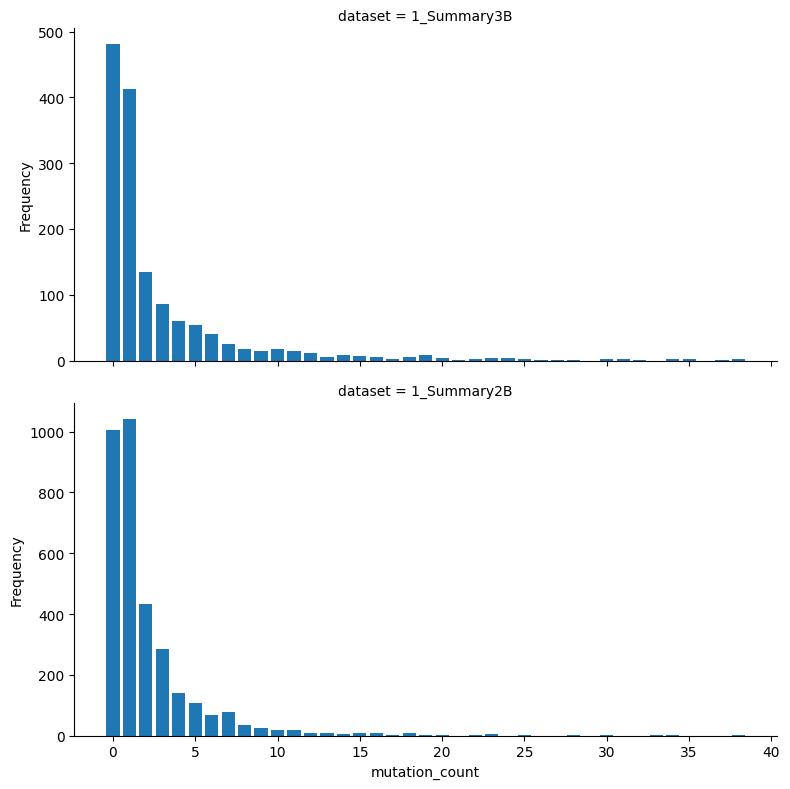

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the number of unique datasets
num_datasets = chigy_believable['dataset'].nunique()

# Find the maximum mutation count to set the bin edges
max_mutation_count = chigy_believable['mutation_count'].max()
bin_edges = range(0, max_mutation_count + 2)  # +1 for inclusive last bin, +1 for the rightmost edge

# Set up the FacetGrid
g = sns.FacetGrid(chigy_believable, row="dataset", height=4, aspect=2, sharex=True, sharey=False)

# Map a histogram to each subplot
g.map(plt.hist, "mutation_count", bins=bin_edges, align='left', rwidth=0.8)

# Adjust the subplot parameters for better layout
g.fig.subplots_adjust(hspace=0.4)  # adjust the space between plots

# Set y-axis label and make the layout tight
g.set_axis_labels(y_var="Frequency")
plt.tight_layout()

# Show the plots
plt.show()


In [16]:
pretty_print_alignments(chigy_believable[chigy_believable["mutation_count"] == 1].head())

> 1_Summary3B 50
------------------------------------------------------------------------------------------GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACTAAGCTAGAAATAAAAC
                                                                                          ||||||||||||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||     
GGAAGCATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTGTGGTTGTCTGGTGTTGATGGAGACATTGTGATGACTCAGTCTCAACAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCT

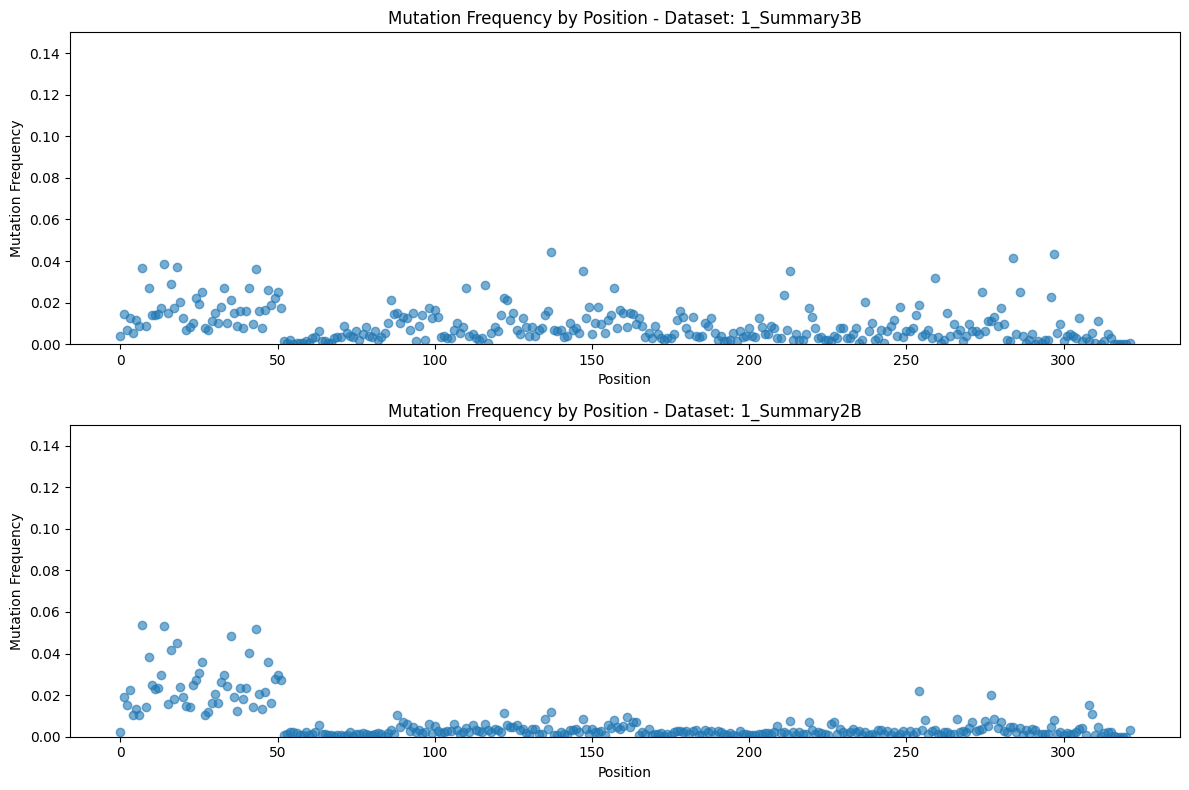

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Get the unique datasets
unique_datasets = chigy_believable['dataset'].unique()

# Set up the figure and the array of subplots
fig, axs = plt.subplots(len(unique_datasets), 1, figsize=(12, 4*len(unique_datasets)))

# Iterate over unique datasets and create a subplot for each one
for index, dataset in enumerate(unique_datasets):
    # Get the ax for this subplot
    ax = axs[index] if len(unique_datasets) > 1 else axs
    
    # Filter DataFrame for this dataset 
    filtered_df = chigy_believable[chigy_believable['dataset'] == dataset]
    
    # Find the maximum value in the mutation_positions column to know the size of the array
    max_position = filtered_df['mutation_positions'].apply(lambda x: max(x) if x else 0).max()
    
    # Initialize the numpy array with zeroes
    mutation_counts_by_position = np.zeros(max_position + 1, dtype=int)
    
    # Iterate through the mutation_positions column and increment the corresponding position in the array
    for positions in filtered_df['mutation_positions']:
        if positions:  # Check if the list is not empty
            for position in positions:
                mutation_counts_by_position[position] += 1
    
    # Calculating Mutation Frequency by dividing by the total read count in the current dataset
    total_read_count = len(filtered_df)
    mutation_frequency_by_position = mutation_counts_by_position / total_read_count
    
    # Plotting
    ax.scatter(range(len(mutation_frequency_by_position)), mutation_frequency_by_position, alpha=0.6)
    ax.set_title(f'Mutation Frequency by Position - Dataset: {dataset}')
    ax.set_xlabel('Position')
    ax.set_ylabel('Mutation Frequency')
    ax.set_ylim(0, 0.15)

plt.tight_layout()
plt.show()


In [26]:
pretty_print_alignments(chigy_believable.sample(500))

> 1_Summary2B 12121
------------------------------------------------------------------------------------------GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACTAAGCTAGAAATAAAAC
                                                                                          ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||     
GGAAGCATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTTTGTGGTTGTCTGGTGTTGATGGAGACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCA

In [24]:
# Define the name of the fasta file
filename = 'sequences.fasta'

# Open the file in write mode to write the chigy_lc_stop_trimmed sequence
with open(filename, 'w') as file:
    file.write('>chigy_lc_stop_trimmed\n')
    file.write(chigy_lc_stop_trimmed + '\n')

# Now, open the file in append mode to add sequences from the dataframe
with open(filename, 'a') as file:
    for index, row in chigy_believable.iterrows():
        header = '>' + row['dataset'] + str(row['Sequence number']) + '\n'
        sequence = row['Sequence'] + '\n'
        file.write(header)
        file.write(sequence)
